# In Process monitoring with Python

In [1]:

import time
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.ticker as ticker

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Intro:**  
In process control chart is a critical tool in development and manufacturing to study how a process changes over time. In this case study, we will look at the typical control strategy implemented for a pharmaceutical material used in the production processs. The critical quality attribute chosen for this raw material is conductivity. In this case study, we will have 2 sets of data:  
1. An acceptable set of conductivity value that can be used to set specification  
2. A set of raw measurements of conductivity at different location which will be used as test data to monitor process performance over time.

In [2]:
# Read in  Conductivity data that will be used to set specification limit  
conductivity_df = pd.read_excel(r'C:\Users\dvu\Data_Projects\playground\XLS\Conductivity_CC.xlsx', header=0, sheet_name="Conductivity_CC")
conductivity_spec_data = conductivity_df["Conductivity"].values

The summary of statistics for the conductivity values is as follows

In [3]:
print(conductivity_df["Conductivity"].describe())

count    24.000000
mean      0.538922
std       0.038291
min       0.469929
25%       0.511518
50%       0.539536
75%       0.576339
max       0.601643
Name: Conductivity, dtype: float64


c:\Users\dvu\anaconda3\envs\vis_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

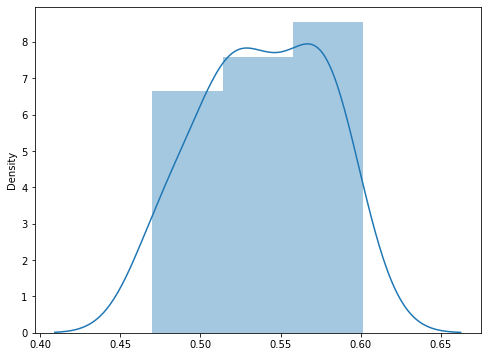

In [4]:
#plot distribution of conductivity data
sns.distplot(conductivity_spec_data, hist=True, kde=True)

This is a continuous feature. The data is slightly skewed to the right. The data is collected using individual measurements. The distribution of the data is known to be normal and thus the control chart chosen is the X-bar and R chart.

In [5]:
# Sanity check
# check if the data is normally distributed using the shapiro-wilk test
from scipy.stats import shapiro
stat, p = shapiro(conductivity_spec_data)
if p > 0.05:
    print('Probably Normal')
else:
    print('Probably not Normal')

Probably Normal


The data we have is confirmed to be likely normal and follows the gaussian distribution. 


This data can be used to set specification limits for the process. Specification limits can be calucalted using the following formula:

In [6]:
#import CSV file containing control chart standards
df = pd.read_csv(r'C:\Users\dvu\Data_Projects\playground\CSV\CtrChartConstant.csv', header=0)

df.head(3)

,n,d2,c4,d3,c5,e1,A2,A3,B3,B4,D3,D4
0,2,1.128,0.797885,0.8525,0.602810,NaN,1.880,2.659,0.0,3.267,0.0,3.267
1,3,1.693,0.886227,0.8884,0.463251,1.160,1.023,1.954,0.0,2.568,0.0,2.574
2,4,2.059,0.921318,0.8794,0.388810,1.093,0.729,1.628,0.0,2.266,0.0,2.282


With this particular quality attribute, the required tolerance interval needs to be set at 95% confidence over 99.9% of the population. This way, the expected Out of Specification (OOS) rejection rate is less than 65 Part Per Million (PPM). In other words, this will have a 95% confidence that the process is within specification 99.9% of the time. This process would have a coverage of roughly 1.33 cpk 
  
Since there are only 24 observation (<30 observations), the K factor will be calculated using the formula as suggested by NIST:  
https://www.itl.nist.gov/div898/handbook/prc/section2/prc263.htm

NOTE: if the sample size is less than 30, the K factor will be calculated using the non-central t distribution adjustment. This way the tolerance intervals wont be calculated too conservatively for smaller sample size

In [7]:
def one_side_k_factor(samplesSize, confidence_alpha, population_quantile):
    from scipy.stats import norm, nct
    zp = norm.ppf(population_quantile)
    zc = norm.ppf(confidence_alpha)

    nc = zp* np.sqrt(samplesSize)

    if samplesSize < 30:
        k = nct.ppf(confidence_alpha, samplesSize-1, nc) / np.sqrt(samplesSize)
    else:

        a = 1 - (zc**2 / (2 * (samplesSize-1)))

        b = zp**2 - (zc**2 /samplesSize)

        k = (zp + np.sqrt(zp**2- a*b)) / a

    return k


In [8]:
def get_oneside_tolerance(data,  confidence_alpha, population_quantile, lim = "upper"):
    # data: array of data
    N = len(data)
    k = one_side_k_factor(N, confidence_alpha, population_quantile)
    assert lim in ("upper", "lower") , "lim must be either upper or lower"
    x_bar = np.mean(data)
    s = np.std(data)
    # calculate the tolerance interval for the upper limit
    if lim == "upper":
        return x_bar + k * s
    else:
        return x_bar - k * s
        

In [9]:
USL = get_oneside_tolerance(conductivity_spec_data, 0.95, 0.999, lim = "upper")

Thus the Upper Specification Limit using this chart will be set at: **USL = 0.696**

Once the specification limit is known, we can calculate control chart parameters:

In [10]:
#define the class X_and_mR for plotting control chart
class X_and_mR:
    
    def __init__(self, array_in):
        
        self.x_bar = None
        self.mR_bar = None
        self.mr = []
        self.array_in = array_in
        self.n = len(array_in)
        #constants look ups
        self.d2 = 1.128#d2[self.n]
        self.D4 = 3.267#D4[self.n]

    def get_x_bar(self):
        array_in = self.array_in
        self.x_bar = statistics.mean(array_in)
        return self.x_bar
    
    def get_mR(self):
        array_in = self.array_in

        mr_list = [abs(array_in[i]-array_in[i-1]) for i in range(1, len(array_in))]
        self.mr = mr_list
        return self.mr

    def get_mR_bar(self):
        self.mr = self.get_mR()
        self.mR_bar = np.sum(self.mr)/(len(self.mr))
        return self.mR_bar

    def get_x_CL(self):
        self.x_bar = self.get_x_bar()
        self.mR_bar = self.get_mR_bar()
        LCL = self.x_bar - self.d2*self.mR_bar
        UCL = self.x_bar + self.d2*self.mR_bar
        return LCL, UCL

    def get_mR_CU(self):
        self.mR_bar = self.get_mR_bar()
        LCL = 0
        UCL = self.D4*self.mR_bar
        return LCL, UCL

    def get_sigma(self):
        self.mR_bar = self.get_mR_bar()
        return self.mR_bar/self.d2


In [11]:
# Read in Conductivity data from excel file
conductivity_df = pd.read_excel(r'C:\Users\dvu\Data_Projects\playground\XLS\RODI_CC.xls', header=0, sheet_name='Conductivity')

conductivity_df.head(3)

,Collection Date,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_G,Location_H,Tap Water,Notes
0,2020-11-30,0.582,0.580,0.591,0.557,0.504,0.567,0.405,0.286,295.9,NaN
1,2020-12-07,0.356,0.535,0.516,0.529,0.463,0.505,0.389,0.509,306.4,NaN
2,2020-12-14,0.375,0.393,0.444,0.440,0.446,0.454,0.496,0.706,NaN,Site shut down


### Data Cleaning:
1. Remove any duplicate data
2. Remove any data that is not a number
3. Load data on to a control chart

In [12]:
#check for duplicate data
conductivity_df.duplicated().sum()

0

No duplicate data was found

In [13]:
# get data types for all columns
conductivity_df.dtypes

Collection Date    datetime64[ns]
Location_A                float64
Location_B                float64
Location_C                float64
Location_D                float64
Location_E                float64
Location_F                float64
Location_G                float64
Location_H                float64
Tap Water                 float64
Notes                      object
dtype: object

Other than dates, data is in float format. No data cleaning is required here

In [14]:

#get the locked control chart setting
control_chart_object = X_and_mR(conductivity_spec_data) #data from the known validated data
x_bar = control_chart_object.get_x_bar()
mR_bar = control_chart_object.get_mR_bar()
sigma = control_chart_object.get_sigma()
LCL, UCL = control_chart_object.get_x_CL()
LCL_mR, UCL_mR = control_chart_object.get_mR_CU()

#add control chart settings to dataframe
# conductivity_df['x_bar'] = x_bar
# conductivity_df['mR_bar'] = mR_bar
# conductivity_df['sigma'] = sigma
# conductivity_df['LCL'] = LCL
# conductivity_df['UCL'] = UCL
# conductivity_df['LCL_mR'] = LCL_mR
# conductivity_df['UCL_mR'] = UCL_mR


In [15]:
conductivity_df.head(3)

,Collection Date,Location_A,Location_B,Location_C,Location_D,Location_E,Location_F,Location_G,Location_H,Tap Water,Notes
0,2020-11-30,0.582,0.580,0.591,0.557,0.504,0.567,0.405,0.286,295.9,NaN
1,2020-12-07,0.356,0.535,0.516,0.529,0.463,0.505,0.389,0.509,306.4,NaN
2,2020-12-14,0.375,0.393,0.444,0.440,0.446,0.454,0.496,0.706,NaN,Site shut down


Plot data on control chart


In [16]:
#remove Notes
conductivity_df = conductivity_df.drop(['Notes'], axis=1)
conductivity_df = conductivity_df.drop(['Tap Water'], axis=1)

In [17]:
conductivity_df.set_index('Collection Date', inplace=True)

In [18]:
# conductivity_df.set_index('Collection Date', inplace=True)
df_stack = conductivity_df.stack().reset_index()
df_stack.columns = ['Collection Date', 'Parameter', 'Value']



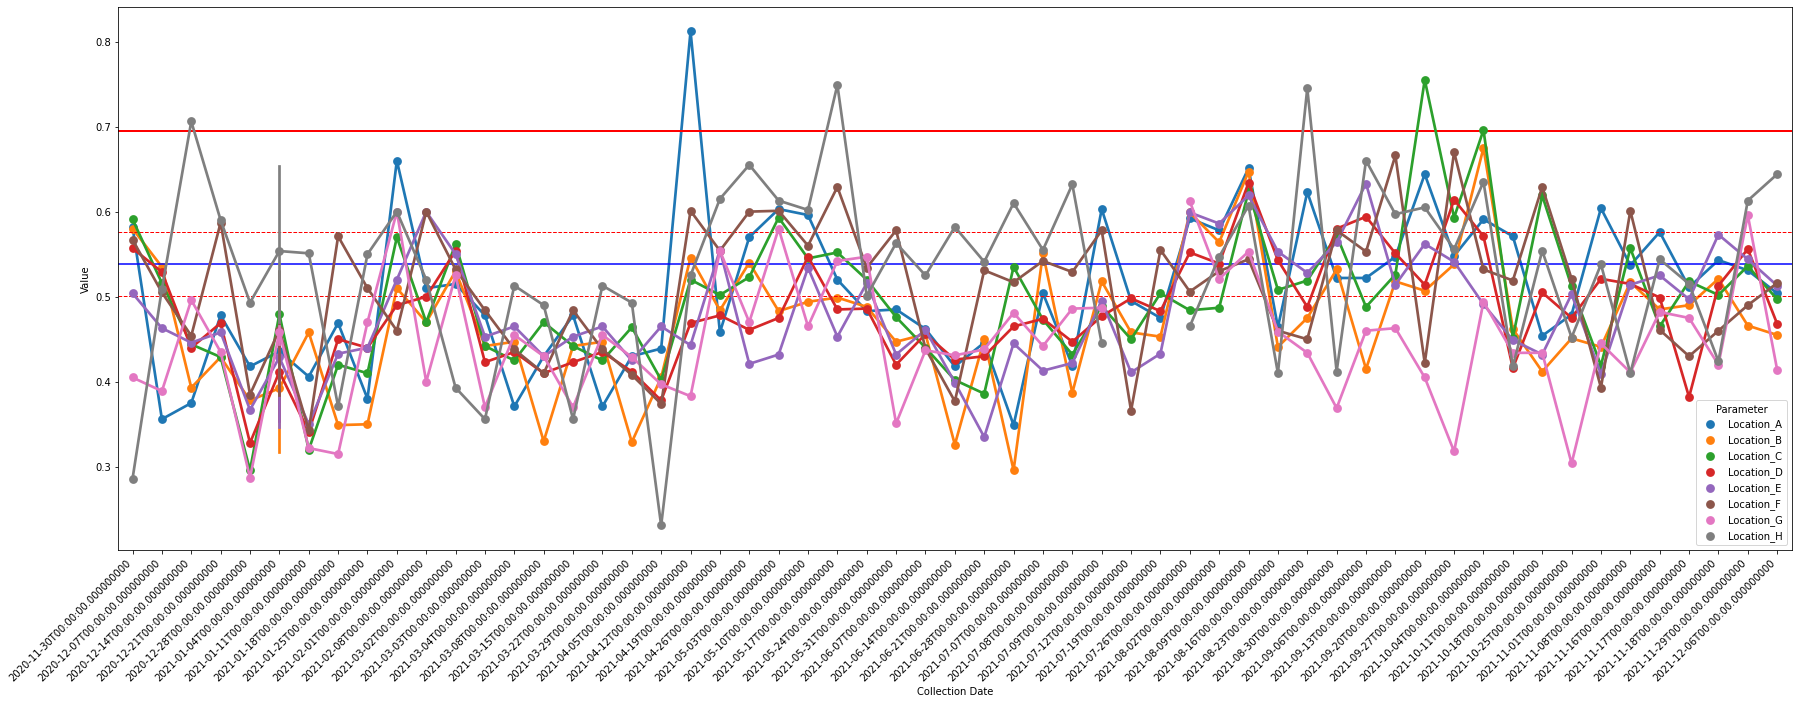

In [19]:
cc = sns.pointplot(x='Collection Date', y='Value', hue='Parameter', data=df_stack)
cc.axhline(y=UCL, color='r', linestyle='--', linewidth=1)
cc.axhline(y=LCL, color='r', linestyle='--', linewidth=1)
cc.axhline(y=x_bar, color='b')
#Thick line for the upper and lower control limits

cc.axhline(y=USL, color='r', linewidth=2)
#rotate x-axis labels
cc.set_xticklabels(cc.get_xticklabels(), rotation=45, horizontalalignment='right')
# set control chart ratio to wide screen
cc.figure.set_size_inches(30, 10)
plt.show()
